# Finetune Llama-3.1 8B with torchtune

This tutorial demonstrates how to fine-tune the Llama-3.1 8B large language model (LLM) on AMD ROCm GPUs by leveraging torchtune. Torchtune is a PyTorch library for easily authoring, post-training, and experimenting with LLMs. It provides: 1) Hackable training recipes for SFT, knowledge distillation, RL and RLHF, and quantization-aware training. 2) Simple PyTorch implementations of popular LLMs like Llama, Gemma, Mistral, Phi, Qwen, and more. 3) OOTB best-in-class memory efficiency, performance improvements, and scaling, utilizing the latest PyTorch APIs. 4) YAML configs for easily configuring training, evaluation, quantization or inference recipes. For more information, see [Torchtune github official page](https://github.com/pytorch/torchtune).

## Prerequisites

This tutorial was developed and tested using the following setup. 

### Operating system

* **Ubuntu 22.04**: Ensure your system is running Ubuntu version 22.04.

### Hardware

* **AMD Instinct™ GPUs**: This tutorial was tested on an AMD Instinct MI300X GPU. Ensure you are using an AMD Instinct GPU or compatible hardware with ROCm support and that your system meets the [official requirements](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/reference/system-requirements.html).

### Software

* **ROCm 6.x**: Install and verify ROCm by following the [ROCm install guide](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/install/quick-start.html). After installation, confirm your setup using:

    ``` bash
    rocm-smi
    ```

    This command lists your AMD GPU(s) with relevant details, similar to the image below.

   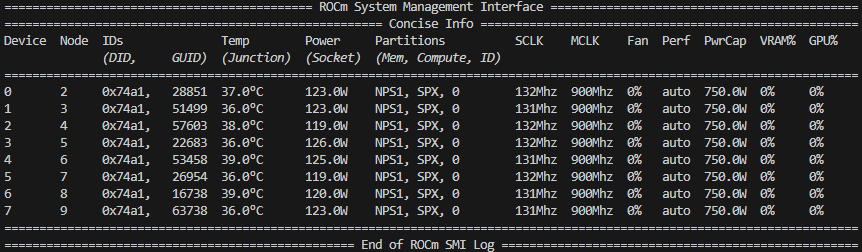


* **Docker**: Ensure Docker is installed and configured correctly. Follow the Docker installation guide for your operating system.

   **Note**: Ensure the Docker permissions are correctly configured. To configure permissions to allow non-root access, run the following commands:

   ``` bash
   sudo usermod -aG docker $USER
   newgrp docker
   ```

   Verify Docker is working correctly:

   ``` bash
   docker run hello-world
   ```

### Hugging Face API access

* Obtain an API token from [Hugging Face](https://huggingface.co) for downloading models.
* Ensure the Hugging Face API token has the necessary permissions and approval to access [Meta's Llama checkpoints](https://huggingface.co/meta-llama/Llama-3.2-3B).

### Data preparation

* This tutorial uses a sample dataset from Hugging Face, which is prepared during the setup steps.


## Prepare the training environment

### 1. Pull the Docker image

Ensure your system meets the [System Requirements](https://rocm.docs.amd.com/projects/install-on-linux/en/latest/reference/system-requirements.html).

Pull the Docker image required for this tutorial:

``` bash
docker pull rocm/pytorch-training:latest
```

### 2. Launch the Docker container

Launch the Docker container and map the necessary directories. Replace `/path/to/notebooks` with the full path to the directory on your host machine where these notebooks are stored.

``` bash
docker run -it --rm \
  --network=host \
  --device=/dev/kfd \
  --device=/dev/dri \
  --group-add=video \
  --ipc=host \
  --cap-add=SYS_PTRACE \
  --security-opt seccomp=unconfined \
  --shm-size 8G \
  --hostname=ROCm-FT \
  -v $(pwd):/workspace \
  -w /workspace/notebooks \
  rocm/pytorch-training:latest
```

**Note**: This command mounts the current directory to the `/workspace` directory in the container. Ensure the notebook file is either copied to this directory before running the Docker command or uploaded into the Jupyter Notebook environment after it starts. Save the token or URL provided in the terminal output to access the notebook from your web browser. You can download this notebook from the [AI Developer Hub GitHub repository](https://github.com/ROCm/gpuaidev).

### 3. Install and launch Jupyter

Inside the Docker container, install Jupyter using the following command:

``` bash
pip install jupyter
```

Start the Jupyter server:

``` bash
jupyter-lab --ip=0.0.0.0 --port=8888 --no-browser --allow-root
```

**Note**: Ensure port `8888` is not already in use on your system before running the above command. If it is, you can specify a different port by replacing `--port=8888` with another port number, for example, `--port=8890`.

### 4. Install the required libraries

Install the libraries required for this tutorial. Run the following commands inside the Jupyter notebook running within the Docker container:

In [5]:
# Install PyTorch, torchvision, torchao nightlies
!pip install --pre --upgrade torch torchvision torchao --index-url https://download.pytorch.org/whl/nightly/rocm6.3/
!pip install --pre --upgrade torchtune --extra-index-url https://download.pytorch.org/whl/nightly/rocm6.3/ 
# This note book is verified under torch==2.7.0.dev20250226+rocm6.3, torchao==0.10.0.dev20250227+rocm6.3, torchtune==0.6.0.dev20250226+rocm6.3, torchvision==0.22.0a0+06a925c

Looking in indexes: https://download.pytorch.org/whl/nightly/rocm6.3/
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.6/687.6 kB 14.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/rocm6.3/


Verify the installation:

In [3]:
# Verify the installation and version of the required libraries
!pip list | grep torch

pytorch-triton-rocm     3.2.0+git4b3bb1f8
torch                   2.7.0.dev20250302+rocm6.3
torchdata               0.11.0
torchtitan              0.0.2
torchtune               0.6.0.dev20250302+rocm6.3


Here is the expected output:

```
pytorch-triton-rocm     3.2.0+git4b3bb1f8
torch                   2.7.0.dev20250302+rocm6.3
torchdata               0.11.0
torchtune               0.6.0.dev20250302+rocm6.3
```

### 5. Verify torchtune is ready for ROCm 6.3

To confirm that the package is installed correctly, you can run the following command:

In [6]:
!tune --help

usage: tune [-h] {download,ls,cp,run,validate,cat} ...

Welcome to the torchtune CLI!

options:
  -h, --help            show this help message and exit

subcommands:
  {download,ls,cp,run,validate,cat}
    download            Download a model from the Hugging Face Hub or Kaggle
                        Model Hub.
    ls                  List all built-in recipes and configs
    cp                  Copy a built-in recipe or config to a local path.
    run                 Run a recipe. For distributed recipes, this supports
                        all torchrun arguments.
    validate            Validate a config and ensure that it is well-formed.
    cat                 Pretty print a config, making it easy to know which
                        parameters you can override with `tune run`.


And should see the following output:

```
usage: tune [-h] {download,ls,cp,run,validate,cat} ...

Welcome to the torchtune CLI!

options:
  -h, --help            show this help message and exit

subcommands:
  {download,ls,cp,run,validate,cat}
    download            Download a model from the Hugging Face Hub or Kaggle
                        Model Hub.
    ls                  List all built-in recipes and configs
    cp                  Copy a built-in recipe or config to a local path.
    run                 Run a recipe. For distributed recipes, this supports
                        all torchrun arguments.
    validate            Validate a config and ensure that it is well-formed.
    cat                 Pretty print a config, making it easy to know which
                        parameters you can override with `tune run`.
```


**⚠️ Important: ensure the correct kernel is selected**

If the verification process fails, ensure the correct Jupyter kernel is selected for your notebook.
To change the kernel, follow these steps:

1. Go to the **Kernel** menu.
2. Select **Change Kernel**
3. Select `Python 3 (ipykernel)` from the list.

**Failure to select the correct kernel can lead to unexpected issues when running the notebook.**


### 6. Provide your Hugging Face token

You'll require a Hugging Face API token to access Llama-3.1. Generate your token at [Hugging Face Tokens](https://huggingface.co/settings/tokens) and request access for [Llama-3.1 8B ](https://huggingface.co/meta-llama/Meta-Llama-3.1-8B-Instruct). Tokens typically start with "hf_". 

Run the following interactive block in your Jupyter notebook to set up the token:

**Note**: Uncheck the "Add token as Git credential" option.

In [ ]:
from huggingface_hub import notebook_login, HfApi

# Prompt the user to log in
notebook_login()

Verify that your token was accepted correctly:

In [ ]:
from huggingface_hub import HfApi

try:
    api = HfApi()
    user_info = api.whoami()
    print(f"Token validated successfully! Logged in as: {user_info['name']}")
except Exception as e:
    print(f"Token validation failed. Error: {e}")

## Fine-tuning the model

This section covers the process of setting up and running fine-tuning for the Llama-3.1 model using torchtune. The following steps describe how to set up GPUs, import the required libraries, configure the model and training parameters, and run the fine-tuning process.

**⚠️ Important: ensure the correct kernel is selected**

Ensure the correct Jupyter kernel is selected for your notebook. To change the kernel, follow these steps:

1. Go to the **Kernel** menu.
2. Select **Change Kernel**
3. Select `Python 3 (ipykernel)` from the list.

**Failure to select the correct kernel can lead to unexpected issues when running the notebook.**

### Set and verify the GPU availability

Begin by specifying the GPUs available for fine-tuning. Verify that they are properly detected by PyTorch.

In [1]:
import os
import torch
gpus= [0, 1] # Rank 0 is for MI300x single device finetune, and Rank 0/1 for full 
os.environ.setdefault("CUDA_VISIBLE_DEVICES", ','.join(map(str, gpus)))
# Ensure PyTorch detects the GPUs correctly
print(f"PyTorch detected number of available devices: {torch.cuda.device_count()}") 

PyTorch detected number of available devices: 2


### Downloading Llama model

You can run the following command to download the weights to your local machine. This will also download the tokenizer model and a responsible use guide.

To download Llama3.1, you can run:

In [ ]:
!tune download meta-llama/Meta-Llama-3.1-8B-Instruct \
    --output-dir /tmp/Meta-Llama-3.1-8B-Instruct \
    --ignore-patterns "original/consolidated.00.pth"

Ignoring files matching the following patterns: original/consolidated.00.pth
.gitattributes: 100%|██████████████████████| 1.52k/1.52k [00:00<00:00, 17.1MB/s]
LICENSE: 100%|█████████████████████████████| 7.63k/7.63k [00:00<00:00, 27.9MB/s]
README.md: 100%|███████████████████████████| 44.0k/44.0k [00:00<00:00, 2.09MB/s]
USE_POLICY.md: 100%|███████████████████████| 4.69k/4.69k [00:00<00:00, 19.8MB/s]
generation_config.json: 100%|██████████████████| 184/184 [00:00<00:00, 1.29MB/s]
model-00001-of-00004.safetensors: 100%|████▉| 4.98G/4.98G [00:07<00:00, 655MB/s]
model-00002-of-00004.safetensors: 100%|████▉| 5.00G/5.00G [00:06<00:00, 807MB/s]
model-00003-of-00004.safetensors: 100%|████▉| 4.92G/4.92G [00:06<00:00, 736MB/s]
model-00004-of-00004.safetensors: 100%|████▉| 1.17G/1.17G [00:01<00:00, 591MB/s]
model.safetensors.index.json: 100%|████████| 23.9k/23.9k [00:00<00:00, 4.20MB/s]
original%2Fparams.json: 100%|██████████████████| 199/199 [00:00<00:00, 1.32MB/s]
tokenizer.model: 100%|██████████

### Running finetuning recipes

#### Single GPU traning
You can finetune Llama3.1 8B with LoRA on a single GPU using the following command:

In [3]:
!tune run lora_finetune_single_device --config llama3_1/8B_lora_single_device

Running LoRAFinetuneRecipeSingleDevice with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.FullModelHFCheckpointer
  checkpoint_dir: /tmp/Meta-Llama-3.1-8B-Instruct/
  checkpoint_files:
  - model-00001-of-00004.safetensors
  - model-00002-of-00004.safetensors
  - model-00003-of-00004.safetensors
  - model-00004-of-00004.safetensors
  model_type: LLAMA3
  output_dir: /tmp/torchtune/llama3_1_8B/lora_single_device
  recipe_checkpoint: null
clip_grad_norm: null
compile: false
dataset:
  _component_: torchtune.datasets.alpaca_cleaned_dataset
  packed: false
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: false
epochs: 1
gradient_accumulation_steps: 8
log_every_n_steps: 1
log_peak_memory_stats: true
loss:
  _component_: torchtune.modules.loss.CEWithChunkedOutputLoss
lr_scheduler:
  _component_: torchtune.training.lr_schedulers.get_cosine_schedule_with_warmup
  num_warmup_steps: 100
max_steps_per_epoch: null
metric_

#### Distributed training
For distributed training, tune CLI integrates with torchrun. Note that we must have more than 1 GPU in hand to run distributed training example. To run a full finetune of Llama3.1 8B on two GPUs:

In [2]:
!tune run --nproc_per_node 2 full_finetune_distributed --config llama3_1/8B_full

Running with torchrun...
W0303 07:14:28.922000 95070 site-packages/torch/distributed/run.py:766] 
W0303 07:14:28.922000 95070 site-packages/torch/distributed/run.py:766] *****************************************
W0303 07:14:28.922000 95070 site-packages/torch/distributed/run.py:766] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W0303 07:14:28.922000 95070 site-packages/torch/distributed/run.py:766] *****************************************
Running FullFinetuneRecipeDistributed with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.FullModelHFCheckpointer
  checkpoint_dir: /tmp/Meta-Llama-3.1-8B-Instruct/
  checkpoint_files:
  - model-00001-of-00004.safetensors
  - model-00002-of-00004.safetensors
  - model-00003-of-00004.safetensors
  - model-00004-of-00004.safetensors
  model_type: LLAMA3
  out

### Customize your recipes for Llama

There are two ways in which you can modify configs:

#### Config Overrides

You can directly overwrite config fields from the command line, e.g. We can set batch size to 16 and disable activation checkpoint in the meantime:

In [6]:
!tune run lora_finetune_single_device \
    --config llama3_1/8B_lora_single_device \
    batch_size=16 \
    enable_activation_checkpointing=False 


Running LoRAFinetuneRecipeSingleDevice with resolved config:

batch_size: 16
checkpointer:
  _component_: torchtune.training.FullModelHFCheckpointer
  checkpoint_dir: /tmp/Meta-Llama-3.1-8B-Instruct/
  checkpoint_files:
  - model-00001-of-00004.safetensors
  - model-00002-of-00004.safetensors
  - model-00003-of-00004.safetensors
  - model-00004-of-00004.safetensors
  model_type: LLAMA3
  output_dir: /tmp/torchtune/llama3_1_8B/lora_single_device
  recipe_checkpoint: null
clip_grad_norm: null
compile: false
dataset:
  _component_: torchtune.datasets.alpaca_cleaned_dataset
  packed: false
device: cuda
dtype: bf16
enable_activation_checkpointing: false
enable_activation_offloading: false
epochs: 1
gradient_accumulation_steps: 8
log_every_n_steps: 1
log_peak_memory_stats: true
loss:
  _component_: torchtune.modules.loss.CEWithChunkedOutputLoss
lr_scheduler:
  _component_: torchtune.training.lr_schedulers.get_cosine_schedule_with_warmup
  num_warmup_steps: 100
max_steps_per_epoch: null
metri

**Note**：If you encounter out-of-memory (OOM) errors, reduce the `batch_size` or enable gradient checkpointing. Use rocm-smi to monitor VRAM usage during fine-tuning.

#### Update a Local Copy

You can also copy the config to your local directory and modify the contents directly:

In [5]:
!tune cp llama3_1/8B_lora_single_device ./my_custom_config_llama3_1_8B_lora_single_device.yaml
# Copied to ./my_custom_config_llama3_1_8B_lora_single_device.yaml

Copied file to my_custom_config_llama3_1_8B_lora_single_device.yaml


Then, you can run your custom recipe by directing the tune run command to your local files:

In [7]:
!tune run lora_finetune_single_device --config ./my_custom_config_llama3_1_8B_lora_single_device.yaml

Running LoRAFinetuneRecipeSingleDevice with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.FullModelHFCheckpointer
  checkpoint_dir: /tmp/Meta-Llama-3.1-8B-Instruct/
  checkpoint_files:
  - model-00001-of-00004.safetensors
  - model-00002-of-00004.safetensors
  - model-00003-of-00004.safetensors
  - model-00004-of-00004.safetensors
  model_type: LLAMA3
  output_dir: /tmp/torchtune/llama3_1_8B/lora_single_device
  recipe_checkpoint: null
clip_grad_norm: null
compile: false
dataset:
  _component_: torchtune.datasets.alpaca_cleaned_dataset
  packed: false
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: false
epochs: 1
gradient_accumulation_steps: 8
log_every_n_steps: 1
log_peak_memory_stats: true
loss:
  _component_: torchtune.modules.loss.CEWithChunkedOutputLoss
lr_scheduler:
  _component_: torchtune.training.lr_schedulers.get_cosine_schedule_with_warmup
  num_warmup_steps: 100
max_steps_per_epoch: null
metric_

Check out tune --help for all possible CLI commands and options. For more information on using and updating configs, please refer to torchtune official [deep-dive](https://pytorch.org/torchtune/main/deep_dives/configs.html).

### Custom Datasets

`torchtune` supports finetuning on a variety of different datasets, including instruct-style, chat-style, preference datasets, and more. If you want to learn more about how to apply these components to finetune on your own custom dataset, please check out the provided links along with torchtune API [docs](https://pytorch.org/torchtune/main/api_ref_datasets.html).

### Monitoring GPU memory

To monitor GPU memory during training, run the following command in a terminal:

In [ ]:
!rocm-smi

This command displays memory usage and other GPU metrics to ensure your hardware resources are being optimally used.